# Project: Findind what makes people leave IBM

 ### The purpose of this note is to explore the staff turnover in IBM. The main focus here is to understand:
This dataset is a simulated open data created by IBM scientists which can be found on Kaggle [here](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset/).
What factors influence or are indicative of someone to leave a company earlier than others. To answer this question we must frame the question as an inference question. And in the end, the task at hand is not to classify someone as "stay" or "leave", but to model who will leave (or will probably leave) a company before others. In other words, can we model how long it takes before someone leave a company. This is a task that suits survival analysis.

### TL-DR
- subjective evaluation, namely Job satisfaction, Environment satisfaction turns out to be indicative. HR should make a policy to monior these indicators regularly and be reactive to them.
- over time increases attrition and policy should minimize the need for over time work.
- We cannot detect the effect of performance rating/salary hikes on attrition. However, it would be interesting whether this holds if we know the timing of the salary hike.
- While salary hike does not show any effect here, the monthly salary is significant indicator. The policy change recommendation is, instead of raising salary over the year, to offer more generous compensation in the first place.
- Some factors that affects attrition may be outside the company control, for instant, commute distance, relationship satisfaction etc. 

### Survival Analysis

#### glossary

**1. What is lifetime?**
First off let me say it is quite ridiculous to predict/categorize someone leaving by simply look at how long the person stay at a company; this is what I find on the Internet a lot of people are doing. No one stays in a company longer than 40 years. So it is obvious that after staying for that long they will leave (i.e. retire). Put it other way that the lifetime of working is about 40 years (if one starts early in mid 20s). One does not need machine learning to predict that. So a lot of these Kaggle prediction does seem vacuous. A more rigorous approach must consider what factors are actually informative and can lead to a policy change.

**2. What is hazard?**
Suppose one wants to approach the problem using a simple linear regression to study survival data, what is wrong with that? There are two kinds of problems
: technicality and subject matter.

*Technicality*
- skewed distribution (and only positive)
- censoring

*subject matter*
- we are interested in probability of staying over time, rather than classification (everyone leaves at some point).
- we are interested in the mechanism involved. 

In order to study the mechanism, we posits a function, called, hazard h(t),also known as risk or force of mortality, which is a time varying fuction denoting the rate of leaving. Intuitively as one gets closer to the expected lifetime, the hazard will go up. And hazard is a rate (or probability conditioned no event not happening, but not a probability) so don't be surprised if you see hazard goes up above.

**3. What is censoring?**
In our dataset, there are people who were labeled "stay", but surely they leave at some point. The reason we don't observe them is because we don't follow them long enough. Our data collection ended before we see them leave, so to speak. This is an example of what's called "right censoring". This is equivalent to chopping off the right side of the time-before-leaving distribution. This creates missing data problem. And this is not a kind of random missing, it is a systematic missing. Therefore using simple regression will lead to bias estimation. Specifically, if we use simple regression to model time-of-leaving, it will tend to underestimate. This is because the actual distribution has a long right tail that is missing in our data collection.

### Fortunately, Lifelines package in Python contains a number of useful tools. so we will rely on this package for the analysis.

### Overview
#### 1. Feature engineering
#### 2. Initial exploration of categorical variables.
#### 3. Model fitting using Cox proportional hazard model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lifelines
import matplotlib.dates as md
plt.style.use('classic')
%matplotlib inline

In [2]:
IBM = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [3]:
IBM.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## 1. Feature engineering
1. categorical variables
2. log transformation the data with skewed distribution

In [22]:
IBM.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'IsSingle', 'IsCurrentlyMarried',
       'IsCurrentlyDivorced', 'NonTravel', 'FrequentTravel', 'IsOverTime',
       'IsFemale', 'StartingAge', 'IsR&D', 'IsSales', 'IsLifeSciences',
       'IsPerformance3', 'IsPerformance4', 'IsMedical',
       'IsLifeSciencesandMedical', 'IsNear', 'HasStockOptions',
       'IsH

C:\Users\Virapat\Anaconda3_32bit\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


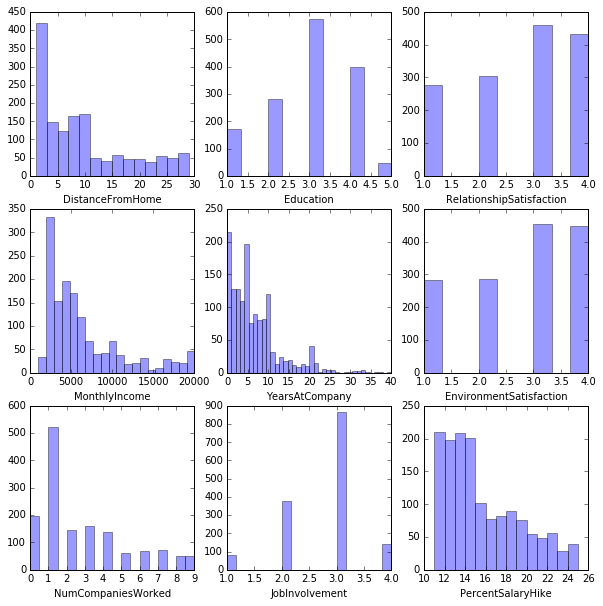

In [27]:
def plot_dist3_3(list_attributes):
    f, ax = plt.subplots(3, 3, figsize = (10,10))
    index = -1
    for i in [0,1,2]:
        for j in [0,1,2]:
            index += 1
            sns.distplot(IBM[list_attributes[index]],kde= False, ax = ax[i,j])
plot_dist3_3(['DistanceFromHome','Education','RelationshipSatisfaction','MonthlyIncome','YearsAtCompany'
              ,'EnvironmentSatisfaction','NumCompaniesWorked','JobInvolvement','PercentSalaryHike'])

Text(0,0.5,'PercentSalaryHike')

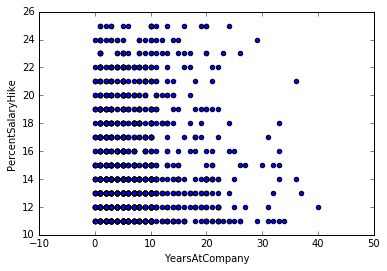

In [5]:
plt.scatter(IBM['YearsAtCompany'],IBM['PercentSalaryHike'])  #look at the relationship between percent salary hike and years at company
plt.xlabel('YearsAtCompany')
plt.ylabel('PercentSalaryHike')  

In [8]:
# 1. categorical variables
IBM['Attrition'] = np.where(IBM['Attrition'] == 'Yes',1,0)
IBM['IsSingle'] = np.where(IBM['MaritalStatus'] == 'Single',1,0)
IBM['IsCurrentlyMarried'] = np.where(IBM['MaritalStatus'] == 'Married',1,0)
IBM['IsCurrentlyDivorced'] = np.where(IBM['MaritalStatus'] == 'Divorced',1,0)
IBM['NonTravel'] = np.where(IBM['BusinessTravel'] == 'Non-Travel',1,0)
IBM['FrequentTravel'] = np.where(IBM['BusinessTravel'] == 'Travel_Frequently',1,0)
IBM['IsOverTime'] = np.where(IBM['OverTime'] == 'Yes',1,0)
IBM['IsFemale'] = np.where(IBM['Gender'] == 'Female',1,0)
#We need to calculate age that people start working in a company. 
IBM['StartingAge'] = IBM['Age'] - IBM['YearsAtCompany']
IBM['IsR&D'] = np.where(IBM['Department'] == 'Research & Development',1,0)
IBM['IsSales'] = np.where(IBM['Department'] == 'Sales',1,0)
IBM['IsLifeSciences'] = np.where(IBM['EducationField'] == 'Life Sciences',1,0)
IBM['IsPerformance3'] = np.where(IBM['PerformanceRating'] == 3,1,0)
IBM['IsPerformance4'] = np.where(IBM['PerformanceRating'] == 4,1,0)
IBM['IsMedical'] = np.where(IBM['EducationField'] =='Medical',1,0)
IBM['IsLifeSciencesandMedical'] = np.where(IBM['EducationField'].isin(['Medical','Life Sciences']),1,0)
IBM['IsNear'] =np.where(IBM['DistanceFromHome'] < 10,1,0)
IBM['HasStockOptions'] = np.where(IBM['StockOptionLevel'] > 0,1,0)
IBM['IsHighSalaryHike'] = np.where(IBM['PercentSalaryHike'] > 15,1,0)

In [9]:
# 2. log transformation
IBM['logMonthlyIncome'] = np.log1p(IBM['MonthlyIncome'])

In [10]:
IBM.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,IsSales,IsLifeSciences,IsPerformance3,IsPerformance4,IsMedical,IsLifeSciencesandMedical,IsNear,HasStockOptions,IsHighSalaryHike,logMonthlyIncome
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,1,1,0,0,1,1,0,0,8.698514
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,0,1,0,1,0,1,1,1,1,8.543056
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,0,0,1,0,0,0,1,0,0,7.645398
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,0,1,1,0,0,1,1,0,0,7.975908
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,0,0,1,0,1,1,1,1,0,8.151622


we separate two kinds of factors. there are more objective kinds that do not depend on evaluation. 
These are 
objective_covariate = ['Age', 'businessTravel', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'Gender', 'HourlyRate', 'MaritalStatus', 'NumCompaniesWorked', 'StockOptionLevel'] Some of these are personal information, some are compensation-related,and some are seniority-related (i.e. having to do with promotion and time working in a company).

And there are evaluative_covariate = ['EnvironmentSatisfaction','JobSatisfaction','PerformanceRating','RelationshipSatisfaction','WorkLifeBalance'].

## For categorical covariates we qualitatively measure the effect by using Kaplan Meier plot.

# 2. Kaplan Meier plot

This gives us an estimate of survival function (i.e. fraction of surviving subjects at a given time). Also it estimates confidence interval for us too.

In [11]:
from lifelines import KaplanMeierFitter

def plot2_2(list_covariates):
    """ 
    from a list of categorical covariates, fit Kaplan Meier estimate. Then display the KM plot result on 2x2 matplotlib format.
    
    """
    kmf = KaplanMeierFitter()
    f, ax = plt.subplots(2, 2, figsize = (10,10))
    index = -1
    for i in [0,1]:
        for j in [0,1]:
            index += 1
            for k in IBM[list_covariates[index]].unique():
                kmf.fit(IBM['YearsAtCompany'][IBM[list_covariates[index]] ==k], event_observed=IBM['Attrition'][IBM[list_covariates[index]] ==k],label=(list_covariates[index] + '  =' + str(k)))
                kmf.plot(ax=ax[i,j], title = list_covariates[index])

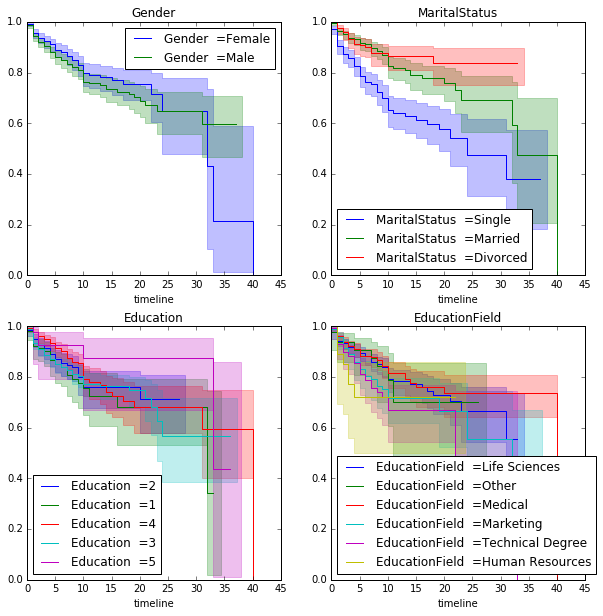

In [12]:
plot2_2(['Gender','MaritalStatus','Education','EducationField'])

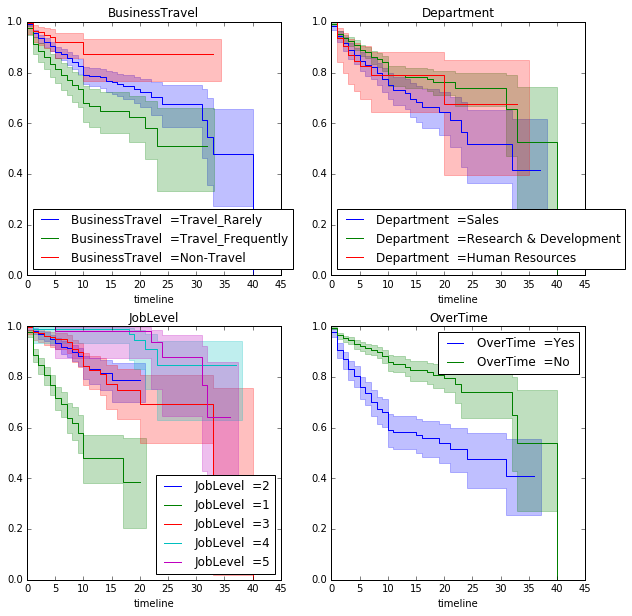

In [13]:
plot2_2(['BusinessTravel','Department','JobLevel','OverTime'])

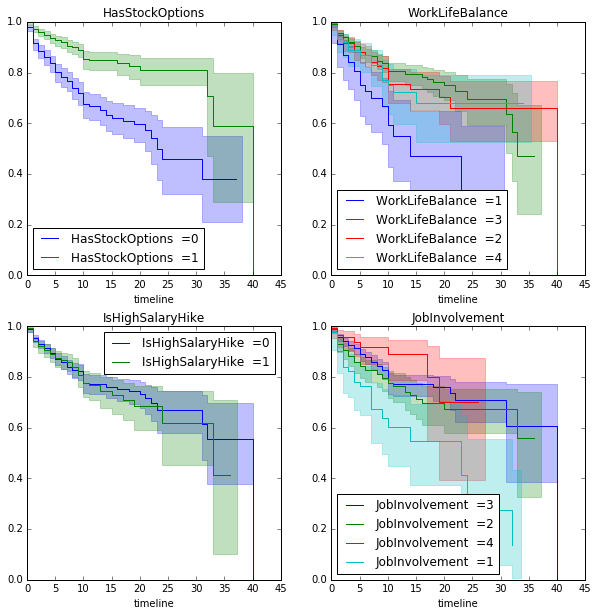

In [14]:
plot2_2(['HasStockOptions','WorkLifeBalance','IsHighSalaryHike','JobInvolvement'])

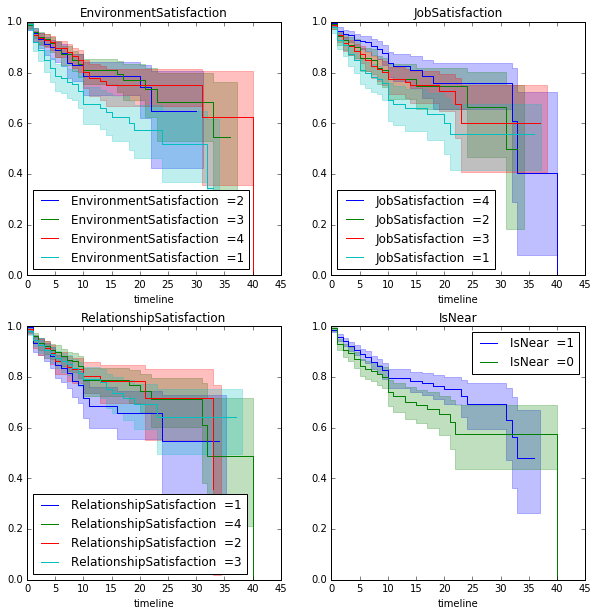

In [15]:
plot2_2(['EnvironmentSatisfaction','JobSatisfaction','RelationshipSatisfaction','IsNear'])

The KM survival plot shows us that doing overtime is predictive of someone leaving (maybe because one gets too burnt out after doing overtime). But importantly one has to examine to see if there is any correlation between the covariates. Recall that the correlation will soaks up the variance. So if the variance is attributed to one covariate, the correlated covariate will be downplayed. Although  this is not really a major problem in predictive task, this can really hurt our inference. So we must examine the correlation.

C:\Users\Virapat\Anaconda3_32bit\lib\site-packages\seaborn\categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


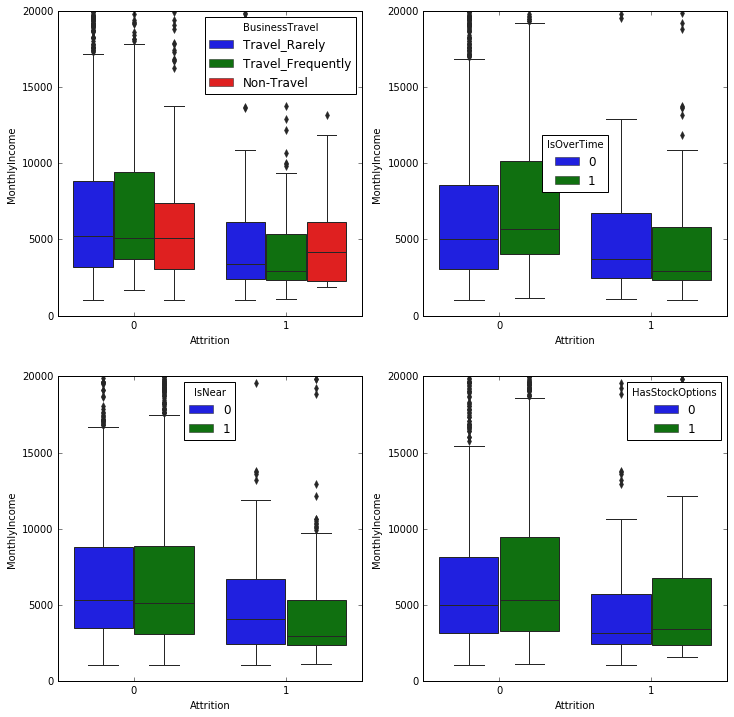

In [28]:
f, ax = plt.subplots(2, 2, figsize = (12,12))
sns.boxplot(IBM['Attrition'],IBM['MonthlyIncome'],IBM['BusinessTravel'], ax =ax[0,0])
sns.boxplot(IBM['Attrition'],IBM['MonthlyIncome'],IBM['IsOverTime'], ax =ax[0,1])
sns.boxplot(IBM['Attrition'],IBM['MonthlyIncome'],IBM['IsNear'], ax =ax[1,0])
sns.boxplot(IBM['Attrition'],IBM['MonthlyIncome'],IBM['HasStockOptions'], ax =ax[1,1])

The boxplot panel above suggests the relationship between whether someone is travelling a lot and the attrition probability; . 

C:\Users\Virapat\Anaconda3_32bit\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


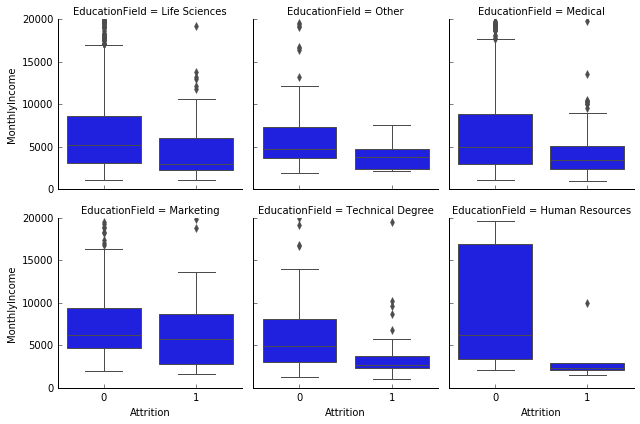

In [29]:
g = sns.FacetGrid(IBM, col = "EducationField", col_wrap =3)
g.map(sns.boxplot, "Attrition","MonthlyIncome")

C:\Users\Virapat\Anaconda3_32bit\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


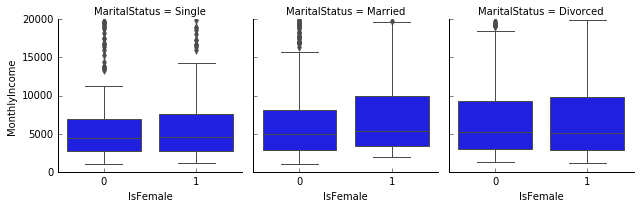

In [30]:
g = sns.FacetGrid(IBM, col = "MaritalStatus", col_wrap =3)
g.map(sns.boxplot, "IsFemale","MonthlyIncome")

# For numerical covariates we use Cox proportional hazard model to perform regression.

## What is Cox regression and why is it proportional?

Imagine we have human population. we may be able to model the survival as a function of age. First we need to find the baseline survival. What we actually model is the mean-centered hazard. Then we can throw in factors that we think hastening or delaying the death. In effect, these factors move ones' survival curve up or down. The Cox proportional assumes that the factor we consider is time-invariant, and the factors has multiplicative effect.
If a factor X has coefficient of $\alpha$, and if X increases by n unit, it will affects the baseline hazard by scaling the hazard by $\alpha^{n}$. This is the meaning of proportional.


### what is concordance index?

Recall our problems with the simple regression. We don't want to model the actual time-of-leaving, but the rate of leaving over time. Using RMSD or similar indicators is meaningless in this context. So how do we know how good our model is?

even though we do not want to model the actual time-of-leaving, we can still rank the order of leaving, i.e. who will probably leave before others. It is similar to our intuition that if someone has cancer, we can't predict the actual time-of-death, but we can still say that probably if we compare the patient to a healthy individual, the patient will probably die first.
Let's carry this logic further, we have many pairs of individuals and we have to order them in the order of who will leave company first. This index is called concordance index. The perfect prediction is 1. And the random prediction is 0.5 (that is if you randomly place individual in line, it is 50% chance someone will leave before the one next in line).


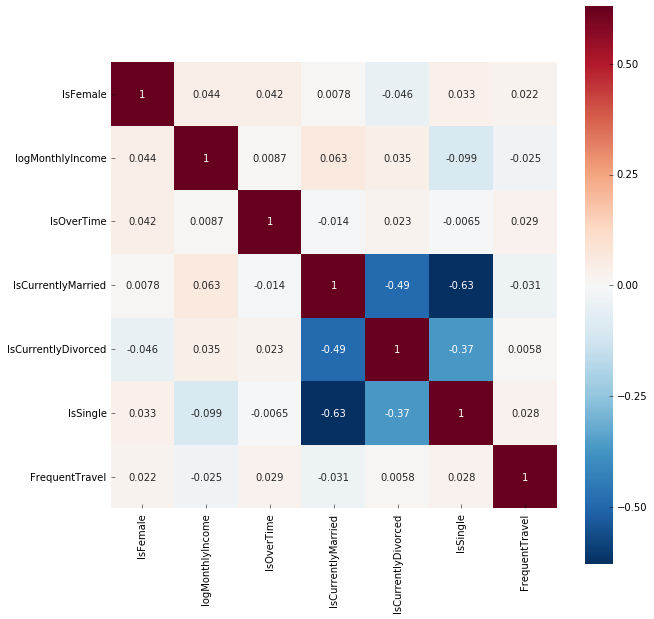

In [67]:
plt.subplots(figsize = (10,10))  # Before we run the cox model, we need to consider whether the covariates are correlated.
sns.heatmap(IBM[['IsFemale','logMonthlyIncome','IsOverTime','IsCurrentlyMarried','IsCurrentlyDivorced','IsSingle','FrequentTravel']].corr(), square = True, annot = True,vmax=.3)

concordance index is ...0.8127631847235397


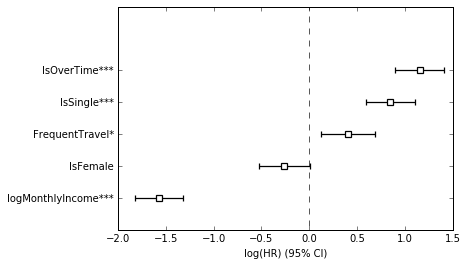

In [69]:
from lifelines import CoxPHFitter
cph_IBM = CoxPHFitter()
f, ax1 = plt.subplots(1,1)
cph_IBM.fit(IBM[['Attrition','YearsAtCompany','IsFemale','logMonthlyIncome','IsOverTime','IsSingle','FrequentTravel']],
                                         duration_col='YearsAtCompany', event_col='Attrition')
cph_IBM.plot(ax =ax1)
ax1.set_ylim(-1,6)
print(('concordance index is ...') + str(cph_IBM.score_))

Note that exponentiated coefficient if > 0 means hastening the attrition. if <0 means delaying the attrition.

We observe that monthlyincome delaying the attrition, let's see if we can see this correlation in the data. Below is the boxplot for that.

C:\Users\Virapat\Anaconda3_32bit\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


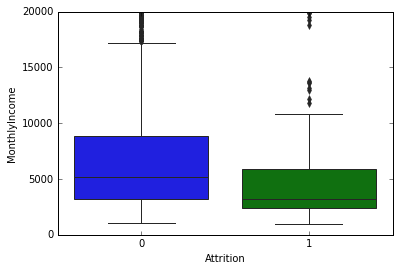

In [44]:
sns.boxplot(IBM['Attrition'],IBM['MonthlyIncome'])

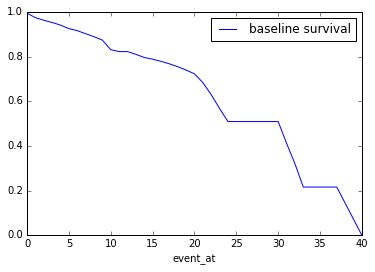

In [45]:
cph_IBM.baseline_survival_.plot()

In [46]:
def plot_Cox(list_attributes):
    f, ax1 = plt.subplots(1,1)
    cph = CoxPHFitter()
    cph.fit(IBM[list_attributes + ['Attrition','YearsAtCompany']], duration_col='YearsAtCompany', event_col='Attrition').plot(ax =ax1)
    ax1.set_ylim([-1,len(list_attributes)])
    print(('concordance index is ...') + str(cph.score_))
def plot_corr(list_attributes):
    sns.heatmap(IBM[list_attributes].corr(), square = True, annot = True,vmax=.3)

concordance index is ...0.7214519374828238


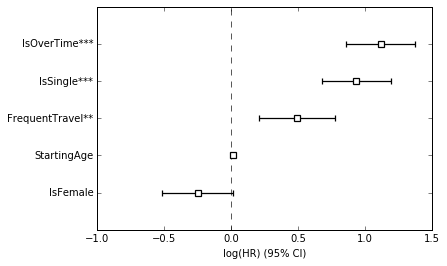

In [47]:
plot_Cox(['IsFemale','IsOverTime','StartingAge','IsSingle','FrequentTravel'])

If we leave off the monthlyincome, the predictive power decreases, while the coefficient of other covariates does not change. The heatmap does not show any obvious correlation with other covariates either. These indicate that monthlyincome in important factor, and should be included.


We will use heatmap to visualize the correlation among the subjective evaluation data. We will leave off the monthly income for now. but will return back. 

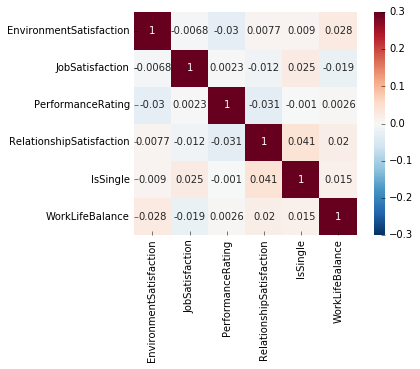

In [70]:
sns.heatmap(IBM[['EnvironmentSatisfaction','JobSatisfaction','PerformanceRating','RelationshipSatisfaction','IsSingle','WorkLifeBalance']].corr(), square = True, annot = True,vmax=.3)

concordance index is ...0.6144582051577557


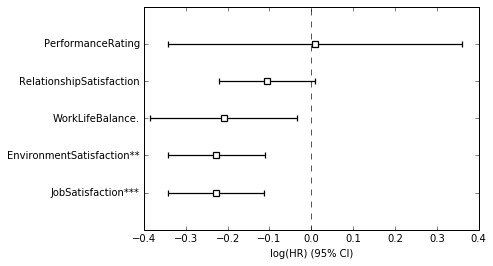

In [71]:
plot_Cox(['EnvironmentSatisfaction','JobSatisfaction','PerformanceRating','RelationshipSatisfaction','WorkLifeBalance'])

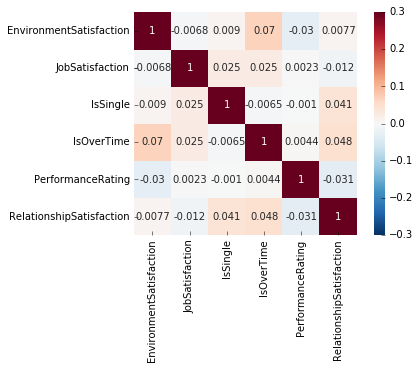

In [73]:
sns.heatmap(IBM[['EnvironmentSatisfaction','JobSatisfaction','IsSingle','IsOverTime','PerformanceRating','RelationshipSatisfaction']].corr(), square = True, annot = True,vmax=.3)

*WorkLifeBalance and RelationshipSatisfaction does not relly show a big effect/ We will discard them from further inquiry*.
Let's include the travel information and monthly income, the overtime, and the performance rating on top of the subjective evaluation. And see how the model is performing. 

concordance index is ...0.8428693008040709


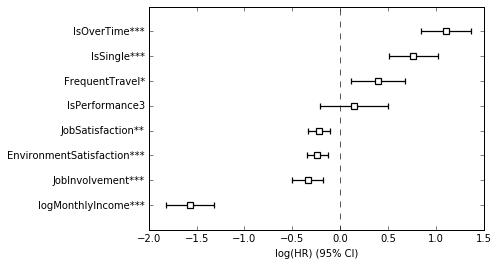

In [74]:
plot_Cox(['EnvironmentSatisfaction','JobSatisfaction','JobInvolvement','logMonthlyIncome','IsSingle','FrequentTravel','IsOverTime','IsPerformance3'])

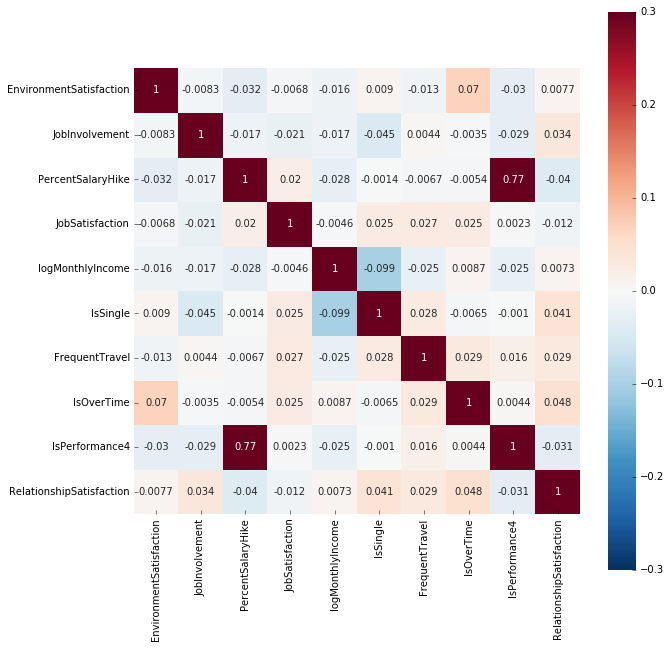

In [53]:
plt.subplots(figsize = (10,10))
plot_corr(['EnvironmentSatisfaction','JobInvolvement','PercentSalaryHike','JobSatisfaction','logMonthlyIncome','IsSingle','FrequentTravel','IsOverTime','IsPerformance4','RelationshipSatisfaction'])

Neither percentsalaryhike, nor performancerating explains attrition! (even though both are correlated).
Let's add the job department (R&D or Sales) to the picture.

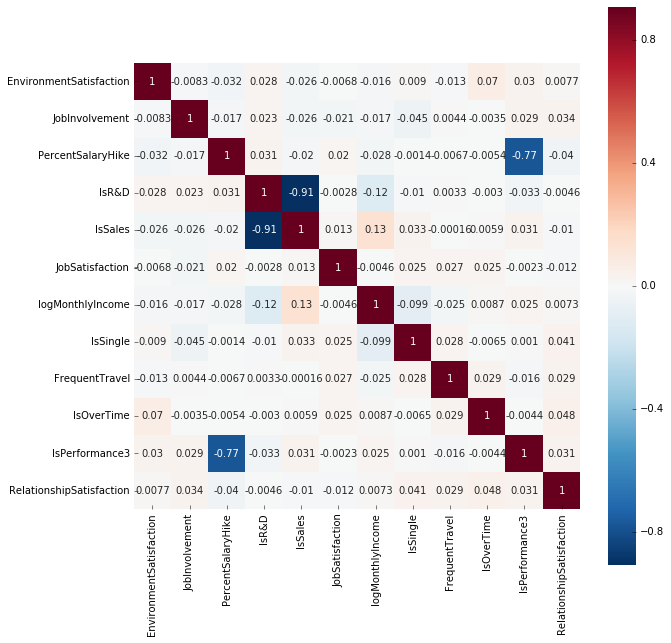

In [75]:
plt.subplots(figsize = (10,10))
plot_corr(['EnvironmentSatisfaction','JobInvolvement','PercentSalaryHike','IsR&D','IsSales','JobSatisfaction','logMonthlyIncome','IsSingle','FrequentTravel','IsOverTime','IsPerformance3','RelationshipSatisfaction'])

C:\Users\Virapat\Anaconda3_32bit\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


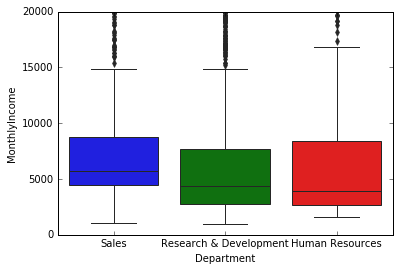

In [80]:
#A detour look at the salary of each department.
sns.boxplot(IBM["Department"],IBM["MonthlyIncome"])
# It seems that the Sales department makes more money than R&D or HR.

concordance index is ...0.8510296894531076


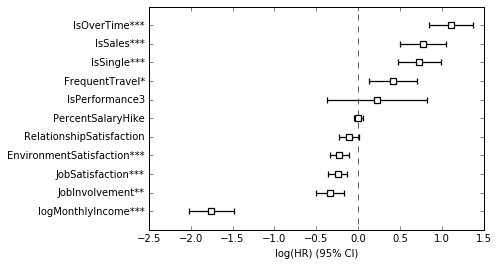

In [55]:
plot_Cox(['EnvironmentSatisfaction','JobInvolvement','PercentSalaryHike','IsSales','JobSatisfaction','logMonthlyIncome','IsSingle','FrequentTravel','IsOverTime','IsPerformance3','RelationshipSatisfaction'])

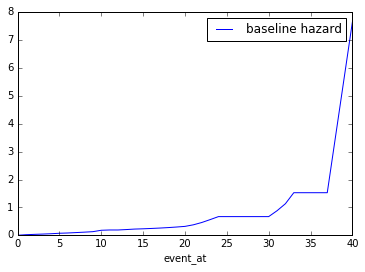

In [56]:
cph_IBM.baseline_cumulative_hazard_.plot()

Text(0.5,1,'baseline hazard plot')

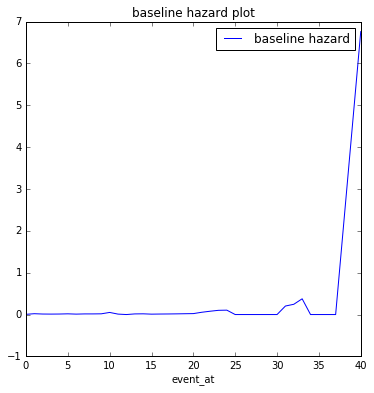

In [79]:
f, ax1 = plt.subplots(1, 1, figsize = (6,6))
cph_IBM.baseline_hazard_.plot(ax = ax1)
ax1.set_ylim(-1,7)
ax1.set_title('baseline hazard plot')

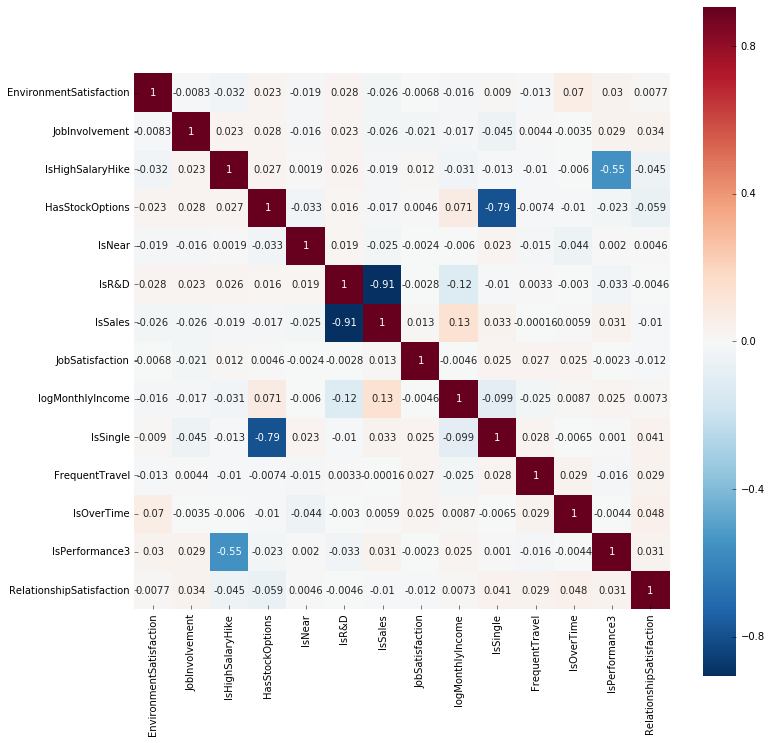

In [58]:
plt.subplots(figsize = (12,12))
plot_corr(['EnvironmentSatisfaction','JobInvolvement','IsHighSalaryHike','HasStockOptions','IsNear','IsR&D','IsSales',
           'JobSatisfaction','logMonthlyIncome','IsSingle','FrequentTravel','IsOverTime','IsPerformance3','RelationshipSatisfaction'])

### This is interesting and something to watch out for.
We see anti-correlation between IsSingle and HasStockOptions, meaning people who has stock options aren't single (maybe they are older?). And we shall see soon that IsSingle is predictive of leaving, while HasStockOptions is predictive of staying. In this case, I don't think one can tell which factor plays role here.

concordance index is ...0.8616102694125052


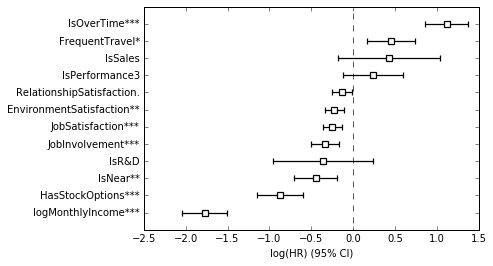

In [59]:
plot_Cox(['EnvironmentSatisfaction','JobInvolvement','HasStockOptions','IsNear','IsR&D','IsSales',
          'JobSatisfaction','logMonthlyIncome','FrequentTravel','IsOverTime','IsPerformance3','RelationshipSatisfaction'])

concordance index is ...0.8569560553541192


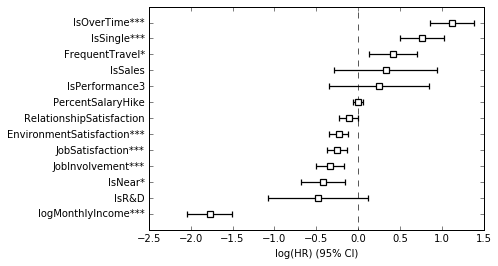

In [60]:
plot_Cox(['EnvironmentSatisfaction','JobInvolvement','PercentSalaryHike','IsSingle','IsNear','IsR&D','IsSales',
          'JobSatisfaction','logMonthlyIncome','FrequentTravel','IsOverTime','IsPerformance3','RelationshipSatisfaction'])

0.860887758087251

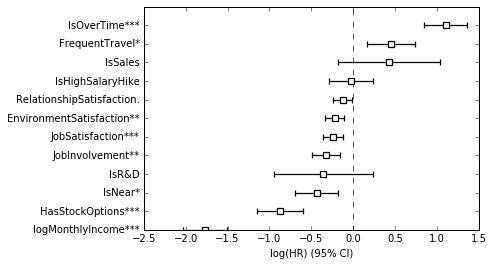

In [61]:
cph_full = CoxPHFitter()
cph_full.fit(IBM[['EnvironmentSatisfaction','JobInvolvement','HasStockOptions','IsNear','IsR&D','IsSales',
          'JobSatisfaction','logMonthlyIncome','FrequentTravel','IsHighSalaryHike','IsOverTime','RelationshipSatisfaction'] + ['Attrition','YearsAtCompany']], 
        duration_col='YearsAtCompany', event_col='Attrition')
cph_full.plot()
cph_full.score_

(-1, 20)

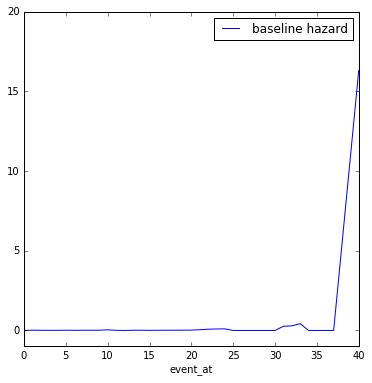

In [65]:
f, ax1 = plt.subplots(1, 1, figsize = (6,6))
cph_full.baseline_hazard_.plot(ax = ax1)
ax1.set_ylim(-1,20)

## Cross-validation.
In fact the concordance here seems really high. Normally concordance ranges from 0.55-0.75 But ours is 0.86 which seems to suggests either our approach has a really high predictive power, or we overfitting in some way.
So let's do some cross validation.

In [66]:
from lifelines.utils import k_fold_cross_validation

cph = CoxPHFitter()
scores = k_fold_cross_validation(cph, IBM[['EnvironmentSatisfaction','JobInvolvement','PercentSalaryHike','HasStockOptions','IsNear','IsR&D','IsSales',
          'JobSatisfaction','logMonthlyIncome','FrequentTravel','IsOverTime','IsPerformance3','RelationshipSatisfaction','Attrition','YearsAtCompany']], 
                                 'YearsAtCompany', event_col='Attrition', k=5)
print(scores)
print(np.mean(scores))
print(np.std(scores))

[0.8942477876106195, 0.8660388463802237, 0.8467269824374667, 0.8002779856730461, 0.8574038132206873]
0.8529390830644086
0.03069113245954513


*So The mean of cross-validation concordance score it really seems to confirm that we do have predictive power.*

# So what's the conclusion...?

**1. Is this model correct?**
The Cox model does have stringent assumption, namely the relationship between the covariate and the hazard must be proportional. We can check if this is true. and in fact it is not. So what can we say about it?
First, even though we may not be able to numerically calculate how much each factor affects the outcome, I think we can infer how they are predictive. And this is a powerful thing about regression, that you actually can intuitively understand it. So that brings us to the next question.

**2. What can we infer?**
We can infer that having more income is really predictive of someone staying in current company. And frequent travellers do move companies. And overtime can make you burn out and quit! 
Another surprising finding is that staying near the company turns out to have a strong effect in preventing someone from leaving. So these gives us a complete picture of the labor supply--that the labor supply is perhaps more monopsonic (single employer controlling major share of labor market) than we think. Again, we do not necessarily know that whether all of the effects we see are causal or constitutive. Some of these may be constitutive (i.e. the kind of person who is suited for the job).

**3. So what does not have an effect?**
Surprisingly, performance has no effect, salaryhike has no effect, or the department (whether it be sales or R&D) does not have any effect.

This is interesting because we think that salary hike is something that should motivate employees to stay, but in fact salary hike is not really correlated with a better indicator such as JobInvolvement, JobSatisfaction, or EnvironmentSatisfaction.

**4. Policy change** 
I think this can inform HR to make a policy change. For example, instead of raising large compensation to keep someon happy, maybe there are other small things the company can do. Having a stock options may be a good idea; or as these indicators suggest, improving the environment satisfaction, or job satisfaction can attract employees without having to raise high compensation. Making someone satisfied in their job without giving them a rise sounds sinister but it is something HR can consider.
